In [22]:
import time
import itertools
import numpy as np
from scipy.optimize import minimize, basinhopping
from qiskit import *
from qiskit.quantum_info import Statevector
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA
from qiskit.opflow.state_fns import StateFn, CircuitStateFn
from qiskit.providers.aer import StatevectorSimulator, AerSimulator
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm
from modules.utils import *
%matplotlib inline
cmap = plt.get_cmap("plasma") #'viridis'
import qiskit
#%matplotlib inline

In [23]:
print(qiskit.__version__)

0.17.4


In [25]:
### Preliminaries
L = 5
num_trash = 2
logspace_size=50

name = f'VQE_Ising_L5_anti_-1_50x50' # _1e-3   # name of the data produced by this notebook
filename = "data/params_" + name   # name of the data file that is used

In [26]:
L = 5
anti = -1.

VQE_params = np.load(filename + ".npz", allow_pickle=True)
gx_list = VQE_params['gx_list']
gz_list = VQE_params['gz_list']
opt_params = VQE_params['opt_params']

gx_vals = np.unique(gx_list)
gz_vals = np.unique(gz_list)

mag = QMag(L,anti) #magnetization operator (Qiskit)
Smag = Mag(L,anti) #magnetization operator (numpy)
# the ~ is the adjoint, but also it turns the is_measurement attribute to True
~StateFn(mag)
# state is technically a circuit, that prepares the ground state via VQE circuit
#state.draw() # uncomment to see, but is very long

Qen=np.zeros(len(opt_params)); Sen=np.zeros(len(opt_params)) #energies
Qmags=np.zeros(len(opt_params)); Smags=np.zeros(len(opt_params)) #magnetizations

In [27]:
load = True

In [28]:
if load:
    temp = np.load(filename + "_mags-Es.npz",allow_pickle=True)
    Qmags = temp["Qmags"]
    Qen = temp["Qen"]
    Sen = temp["Sen"]
    Smags = temp["Smags"]

In [29]:
if not load:
    for j in range(len(opt_params)):

        gx = gx_list[j]
        gz = gz_list[j]
        H = QHIsing(L, anti, np.float32(gx), np.float32(gz)) # build Hamiltonian Op
        state = init_vqe(opt_params[j], L=L)
        StateFn(state)   
        meas_outcome = ~StateFn(mag) @ StateFn(state)

        Qmags[j] = meas_outcome.eval()
        e_outcome = ~StateFn(H) @ StateFn(state)
        Qen[j] = e_outcome.eval()

        init_state, E, ham = ising_groundstate(L, anti, np.float(gx), np.float(gz))
        Sen[j] = E
        Smags[j] = init_state.T.conj()@Smag@init_state #Magnetization with Numpy results
    np.savez(filename + "_mags-Es",Qmags=Qmags, Qen=Qen, Sen=Sen, Smags=Smags) # for large parameter space takes quite a while because of the exact diagonalization

## ED comparison

<ipython-input-30-f3ca36468ff1>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(gz_vals, gx_vals, abs(Smags).reshape(len(gz_vals),len(gx_vals)), cmap=cmap)
<ipython-input-30-f3ca36468ff1>:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(gz_vals, gx_vals, abs(Qmags).reshape(len(gz_vals),len(gx_vals)), cmap=cmap)


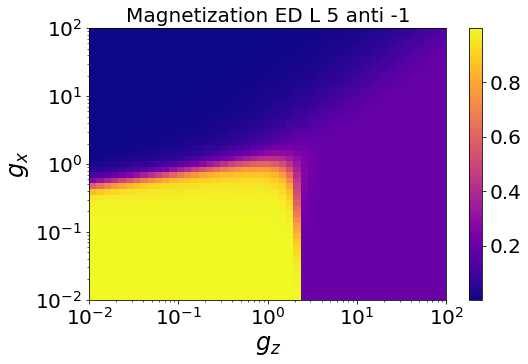

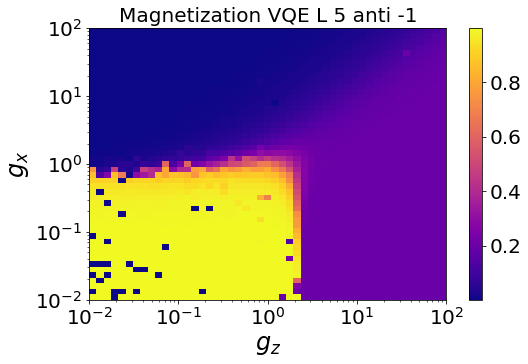

In [30]:
fig,ax = plt.subplots(figsize=(8,5))
cmap = plt.get_cmap("plasma") #'viridis'
im = ax.pcolormesh(gz_vals, gx_vals, abs(Smags).reshape(len(gz_vals),len(gx_vals)), cmap=cmap)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
plt.yscale("log")
ax.set_title("Magnetization ED L %.0f anti %.0f" %(L, anti),fontsize=20)
ax.set_xlabel(r"$g_z$",fontsize=24)
ax.set_ylabel(r"$g_x$",fontsize=24)
ax.tick_params(labelsize=20)

fig,ax = plt.subplots(figsize=(8,5))
cmap = plt.get_cmap("plasma") #'viridis'
im = ax.pcolormesh(gz_vals, gx_vals, abs(Qmags).reshape(len(gz_vals),len(gx_vals)), cmap=cmap)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
plt.yscale("log")
ax.set_title("Magnetization VQE L %.0f anti %.0f" %(L, anti),fontsize=20)
ax.set_xlabel(r"$g_z$",fontsize=24)
ax.set_ylabel(r"$g_x$",fontsize=24)
ax.tick_params(labelsize=20)

<ipython-input-31-f44c804642c6>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(gz_vals, gx_vals, Sen.reshape(len(gz_vals),len(gx_vals)) - Qen.reshape(len(gz_vals),len(gx_vals)), cmap=cmap)


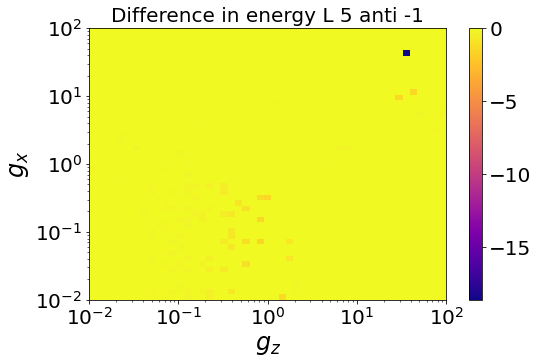

In [31]:
fig,ax = plt.subplots(figsize=(8,5))
cmap = plt.get_cmap("plasma") #'viridis'
im = ax.pcolormesh(gz_vals, gx_vals, Sen.reshape(len(gz_vals),len(gx_vals)) - Qen.reshape(len(gz_vals),len(gx_vals)), cmap=cmap)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
plt.yscale("log")
ax.set_title("Difference in energy L %.0f anti %.0f" %(L, anti),fontsize=20)
ax.set_xlabel(r"$g_z$",fontsize=24)
ax.set_ylabel(r"$g_x$",fontsize=24)
ax.tick_params(labelsize=20)

In [32]:
##############################################################################
### II - Training  ###########################################################
##############################################################################


# Use Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')


thetas = np.random.uniform(0, 2*np.pi, 2*L+2) # initial parameters without feature encoding
# thetas = np.random.uniform(0, 2*np.pi, (2*L+2, 2)) # initial parameters with feature encoding

In [33]:
# linear entangler (as in scales linearly with trash qubits)
def get_entangler_map(L, num_trash, i_permut=1):
    result = []
    nums = list(range(L)) # here was the problem, it doesnt like when list elements are taken from numpy
    nums_compressed = nums.copy()[:L-num_trash]
    nums_trash = nums.copy()[-num_trash:]
    #print(nums, nums_compressed, nums_trash)
    # combine all trash qubits with themselves
    for trash_q in nums_trash[:-1]:
        result.append((trash_q+1,trash_q))
    # combine each of the trash qubits with every n-th
    repeated = list(nums_trash) * (L-num_trash) # repeat the list of trash indices cyclicly
    for i in range(L-num_trash):
        result.append((repeated[i_permut + i], nums_compressed[i]))
    return result

def QAE_Ansatz(thetas, L, num_trash, insert_barriers=False, parametrized_gate = "ry", entangling_gate = "cz"):
    entanglement = [get_entangler_map(L,num_trash,i_permut) for i_permut in range(num_trash)]
    circ = qiskit.circuit.library.TwoLocal(L, 
                                           parametrized_gate,
                                           entangling_gate,
                                           entanglement,
                                           reps=num_trash,
                                           insert_barriers=insert_barriers,
                                           skip_final_rotation_layer=True
                                          ).assign_parameters(thetas[:-num_trash])
    if insert_barriers: circ.barrier()
    for i in range(num_trash):
        circ.ry(thetas[L-i-1], L-i-1)
        #circ.ry(circuit.Parameter(f'θ{i}'), L-i-1)
    return circ

def prepare_circuit(thetas, L=6, num_trash=2, init_state=None, measurement=True, vqe=True):
    qreg = QuantumRegister(L, 'q')
    creg = ClassicalRegister(num_trash, 'c')
    circ = QuantumCircuit(qreg, creg)
    circ += QAE_Ansatz(thetas, L, num_trash, insert_barriers=True)#.assign_parameters(thetas) # difference to bind?
    if measurement:
        for i in range(num_trash):
            circ.measure(qreg[L-i-1], creg[i])
    if init_state is not None:
        if vqe:
            circ = init_vqe(init_state,L=L) + circ
        else:
            circ.initialize(init_state, qreg)
    return circ

In [34]:
def feature_encoding(thetas, x):
    """ thetas: parameters to be optimized, x: Ising model parameter (eg. field) """
    new_thetas = []
    thetas = thetas.reshape((-1,2))
    for theta in thetas:
        new_thetas.append(theta[0] * x + theta[1])
    return new_thetas

### Execute circuit
Circuit is executed on simulator and measurement outcomes on the trash qubits are stored

In [35]:
idx = 30
num_trash = 2
J, gx, gz = -1., gx_list[idx], gz_list[idx] # Ising parameters for which ground state should be compressed
phi = opt_params[idx] # train on smallest lambda ;; this may grammatically be confusing, init_state = dictionary with unsorted parameters

def run_circuit(thetas, L, num_trash, init_state, vqe=True, shots=100):
    circ = prepare_circuit(thetas, L, num_trash, init_state, vqe=vqe)

    # Execute the circuit on the qasm simulator.
    job_sim = execute(circ, backend_sim, shots=shots, seed_simulator=123, seed_transpiler=234) # fix seed to make it reproducible

    # Grab the results from the job.
    result_sim = job_sim.result()

    counts = result_sim.get_counts(circ)
#     print(counts)
    
#     mems = result_sim.get_memory(circ)
#     print(mems)
    return counts
run_circuit(thetas, L, num_trash, phi)['11']

25

### Optimize circuit
Define cost function (averaged hamming distance of measurement outcomes) and minimze it using either scipy or qiskit optimizer modules (the latter is also based on scipy though).

In [36]:
# translate to Rikes naming
phis = opt_params
gxs = gx_list
gzs = gz_list

In [37]:


def cost_function_single(thetas, L, num_trash, p, shots=1000, vqe=True, param_encoding=False, x=0):
    """ Optimizes circuit """
    if vqe:
        init_state = phis[p]
    else:
        J, gx, gz = p
        init_state, _ = ising_groundstate(L, J, gx, gz)
    if param_encoding: thetas = feature_encoding(thetas, x) 
    out = run_circuit(thetas, L, num_trash, init_state, vqe=vqe, shots=shots)
    cost = out.get('11', 0)*2 + out.get('01', 0) + out.get('10', 0)
    return cost/shots

def cost_function(thetas, L, num_trash, ising_params, shots=1000, vqe=True, param_encoding=False, x=0):
    """ Optimizes circuit """
    cost = 0.
    n_samples = len(ising_params)
    for i, p in enumerate(ising_params):
        if param_encoding: 
            cost += cost_function_single(thetas, L, num_trash, p, shots, vqe, param_encoding, x[i])
        else:
            cost += cost_function_single(thetas, L, num_trash, p, shots, vqe, param_encoding)
    return cost/n_samples

def optimize(ising_params, L=6, num_trash=2, thetas=None, shots=1000, max_iter=400, vqe=True, param_encoding=False, x=0, pick_optimizer = None):
    if thetas is None:
        n_params = (2*L+2)*2 if param_encoding else (2*L+2)
        thetas = np.random.uniform(0, 2*np.pi, n_params) # initial parameters without feature encoding
        
    print("Initial cost: {:.3f}".format(cost_function(thetas, L, num_trash, ising_params, shots, vqe, param_encoding, x)))
    
    counts, values, accepted = [], [], []
    def store_intermediate_result(eval_count, parameters, mean, std, ac):
        # counts.append(eval_count)
        values.append(mean)
        accepted.append(ac)

    # Initialize optimizer
    if pick_optimizer == "cobyla":
        optimizer = COBYLA(maxiter=max_iter, tol=0.0001)
    if pick_optimizer == "adam" or pick_optimizer == "ADAM":
        optimizer = qiskit.algorithms.optimizers.ADAM(maxiter=max_iter)
    # optimizer = L_BFGS_B(maxfun=300, maxiter=max_iter)#, factr=10, iprint=- 1, epsilon=1e-08)
    if pick_optimizer == "spsa" or pick_optimizer == None:
        optimizer = SPSA(maxiter=max_iter,
                         #blocking=True,
                         callback=store_intermediate_result,
                         #learning_rate=1e-1,
                         #perturbation=0.4
                         ) # recommended from qiskit (first iteraction takes quite long)
                           # to reduce time figure out optimal learning rate and perturbation in advance

    start_time = time.time()
    ret = optimizer.optimize(
                            num_vars=len(thetas),
                            objective_function=(lambda thetas: cost_function(thetas, L, num_trash, ising_params, shots, vqe, param_encoding, x)),
                            initial_point=thetas
                            )
    print("Time: {:.5f} sec".format(time.time()-start_time))
    print(ret)
    return ret[0], values, accepted



In [38]:
x,y = np.meshgrid(gx_vals, gz_vals)

In [39]:
def run_inference(thetas, shots=1000, L=5):
    points = 50
    J = -1.0
    x,y = np.meshgrid(gx_vals, gz_vals)
    cost = np.zeros((len(gx_vals) * len(gz_vals)))
    Smags = np.zeros((len(gx_vals) * len(gz_vals)))
    shots = 1000
    for i,p in enumerate(list(zip(gxs, gzs))):
            cost[i] = cost_function_single(thetas, L, num_trash, i, shots=shots)
    cost = cost.reshape((len(gx_vals), len(gz_vals)))
    return cost

cmap = plt.get_cmap("plasma")
def plot_result(cost):
    fig,axs = plt.subplots(ncols=2,figsize=(15,5))
    nbins=100
    ax = axs[0]
    im = ax.pcolormesh(x, y, cost, cmap=cmap, shading="auto")
    cbar = fig.colorbar(im, ax=ax)
    cbar.ax.tick_params(labelsize=20)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_title(f"Loss",fontsize=20)
    ax.set_xlabel(r"$g_z$",fontsize=24)
    ax.set_ylabel(r"$g_x$",fontsize=24)
    ax.tick_params(labelsize=20)
    for p in params:
        gz = gz_list[p]
        gx = gx_list[p]
        ax.plot(gz,gx,"o",label="training",color="cyan")
    
    ax = axs[1]
    im = ax.pcolormesh(gz_vals, gx_vals, abs(Qmags).reshape(len(gz_vals),len(gx_vals)), cmap=cmap, shading="auto")
    cbar = fig.colorbar(im, ax=ax)
    cbar.ax.tick_params(labelsize=20)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_title("Magnetization VQE L %.0f anti %.0f" %(L, anti),fontsize=20)
    ax.set_xlabel(r"$g_z$",fontsize=24)
    ax.set_ylabel(r"$g_x$",fontsize=24)
    ax.tick_params(labelsize=20)

## Training on bottom-left

In [54]:
#reset random seed
np.random.seed(123)
from qiskit.utils import algorithm_globals
algorithm_globals.random_seed = 123

check dependence on training state with fixed seeds

In [51]:
np.intersect1d(
    np.intersect1d(np.where(gx_list > 5e-2),np.where(1e-1 > gx_list)),
    np.intersect1d(np.where(gz_list > 5e-2),np.where(1e-1 > gz_list))
)   

array([459, 460, 461, 462, 509, 510, 511, 512, 559, 560, 561, 562, 609,
       610, 611, 612])

In [55]:
paramss =[
    [459], # train on bottom left point
    [460],
    [509],
    [560]
]

In [56]:
for i,params in enumerate(paramss):
    print(f"{i} / {len(paramss)} - params (gz, gx) in {[(gzs[p], gxs[p]) for p in params]}")

0 / 4 - params (gz, gx) in [(0.054286754393238594, 0.054286754393238594)]
1 / 4 - params (gz, gx) in [(0.0655128556859551, 0.054286754393238594)]
2 / 4 - params (gz, gx) in [(0.054286754393238594, 0.0655128556859551)]
3 / 4 - params (gz, gx) in [(0.0655128556859551, 0.07906043210907697)]


In [57]:
thetass = [None] * len(paramss)
losss = [None] * len(paramss)
costs = [None] * len(paramss)

## Run 1

1 / 4 - params (gz, gx) in [(0.054286754393238594, 0.054286754393238594)]
Initial cost: 0.612
Time: 24.91055 sec
(array([ 0.2476756 ,  0.86294063, -0.17148363,  0.08433167,  6.26862385,
        2.02919165,  5.36782424,  6.13922404,  3.17724685, -0.02288794,
        3.46865002,  6.33774295]), 0.0, 300)
2 / 4 - params (gz, gx) in [(0.0655128556859551, 0.054286754393238594)]
Initial cost: 1.108
Time: 24.63372 sec
(array([0.02098254, 1.56179204, 3.17212212, 7.1109244 , 3.10089854,
       3.52928328, 4.64628796, 7.72899293, 7.7632128 , 3.13470723,
       8.09581696, 1.26839882]), 0.533, 300)
3 / 4 - params (gz, gx) in [(0.054286754393238594, 0.0655128556859551)]
Initial cost: 1.115
Time: 26.13957 sec
(array([ 3.10220025,  3.13602801,  0.37253037,  3.16751745,  0.43221657,
        3.03364531, -0.88349208,  2.74124392,  3.11415361,  5.36269413,
        3.62711727,  1.34812434]), 0.0, 300)
4 / 4 - params (gz, gx) in [(0.0655128556859551, 0.07906043210907697)]
Initial cost: 0.925
Time: 25.80022

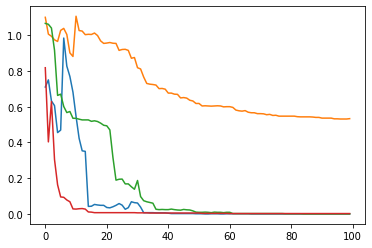

In [58]:
for i,params in enumerate(paramss):
    print(f"{i+1} / {len(paramss)} - params (gz, gx) in {[(gzs[p], gxs[p]) for p in params]}")
    thetas, loss, accepted = optimize(params, max_iter=100, L=5) #, pick_optimizer="adam")
    thetass[i], losss[i] = thetas, loss
    plt.plot(loss)
    cost = run_inference(thetas)
    costs[i] = cost

In [59]:
filename2 = "data/" + name + "_thetas-loss-cost_vary-training-states"

In [60]:
np.savez(filename2, losss = losss, costs = costs, thetass = thetass)

1 / 4 - params (gz, gx) in [(0.054286754393238594, 0.054286754393238594)]


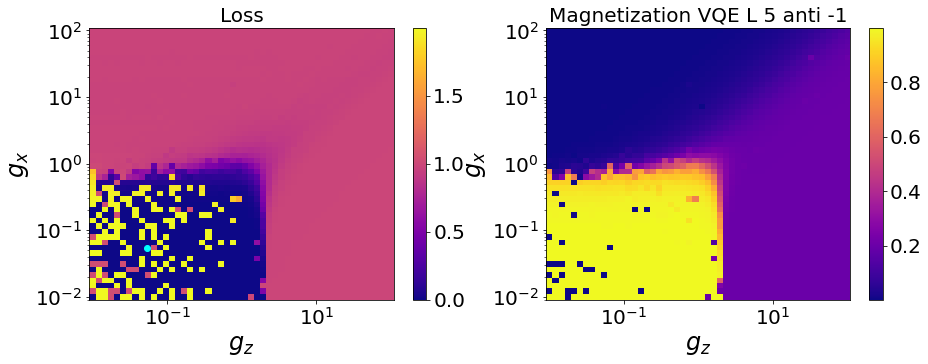

2 / 4 - params (gz, gx) in [(0.0655128556859551, 0.054286754393238594)]


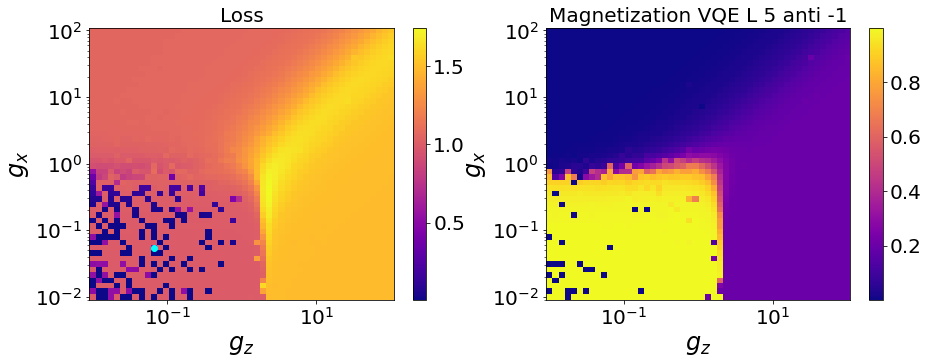

3 / 4 - params (gz, gx) in [(0.054286754393238594, 0.0655128556859551)]


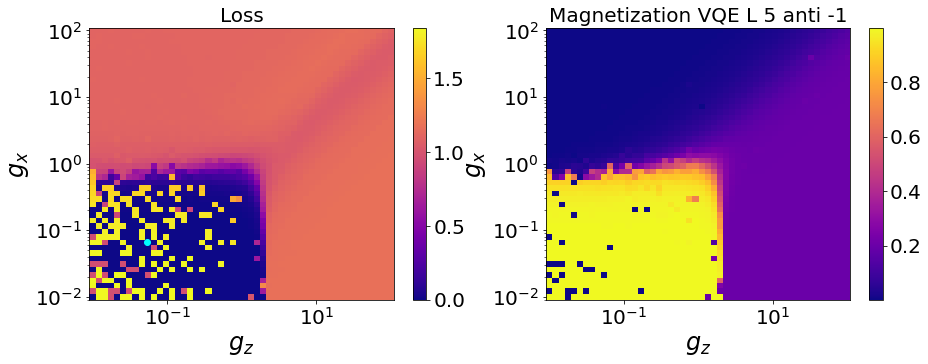

4 / 4 - params (gz, gx) in [(0.0655128556859551, 0.07906043210907697)]


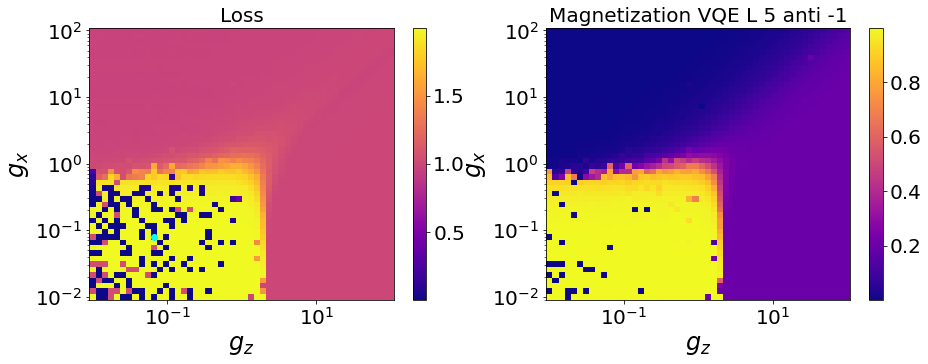

In [61]:
for i,params in enumerate(paramss):
    print(f"{i+1} / {len(paramss)} - params (gz, gx) in {[(gzs[p], gxs[p]) for p in params]}")
    plot_result(np.load(filename2 + ".npz",allow_pickle=True)["costs"][i])
    plt.show()

## Run 1

In [62]:
for i,params in enumerate(paramss):
    print(f"{i+1} / {len(paramss)} - params (gz, gx) in {[(gzs[p], gxs[p]) for p in params]}")
    thetas, loss, accepted = optimize(params, max_iter=100, L=5, pick_optimizer="cobyla") #, pick_optimizer="adam")
    thetass[i], losss[i] = thetas, loss
    cost = run_inference(thetas)
    costs[i] = cost

1 / 4 - params (gz, gx) in [(0.054286754393238594, 0.054286754393238594)]
Initial cost: 0.996
Time: 8.57873 sec
(array([3.43402011, 3.80475731, 1.26483013, 6.23956387, 6.23936587,
       5.09687186, 2.80061448, 2.15879659, 3.06035539, 6.29691421,
       5.50065757, 3.13475934]), 0.002, 100)
2 / 4 - params (gz, gx) in [(0.0655128556859551, 0.054286754393238594)]
Initial cost: 1.082
Time: 7.41191 sec
(array([4.73359263, 3.15791705, 4.6891067 , 5.93893429, 4.65146479,
       1.57823559, 3.96702392, 1.54203067, 0.02446509, 3.09613233,
       0.74354599, 5.70483902]), 0.54, 100)
3 / 4 - params (gz, gx) in [(0.054286754393238594, 0.0655128556859551)]
Initial cost: 0.873
Time: 7.14258 sec
(array([ 3.27352486,  3.23616958, -0.51030687,  2.99036027,  3.48870856,
        2.59294716,  2.53593511,  3.81372142,  3.4181555 ,  5.56082821,
        3.48329269,  2.44724044]), 0.007, 100)


KeyboardInterrupt: 

In [ ]:
filename2 = "data/" + name + "_thetas-loss-cost_vary-training-states_cobyla"

In [ ]:
np.savez(filename2, losss = losss, costs = costs, thetass = thetass)

1 / 4 - params (gz, gx) in [(0.054286754393238594, 0.054286754393238594)]


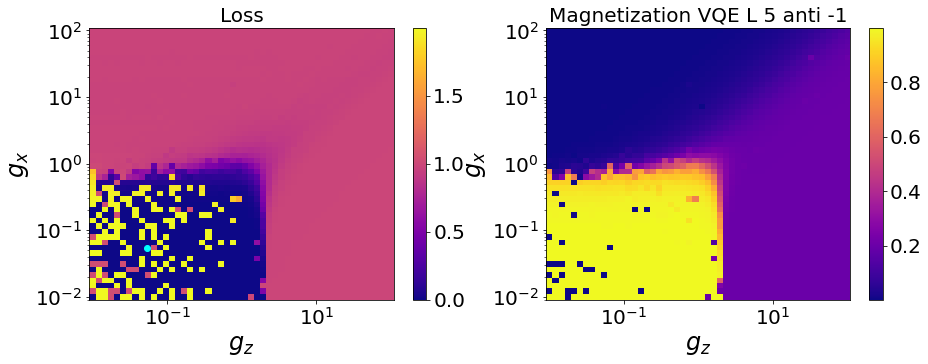

2 / 4 - params (gz, gx) in [(0.0655128556859551, 0.054286754393238594)]


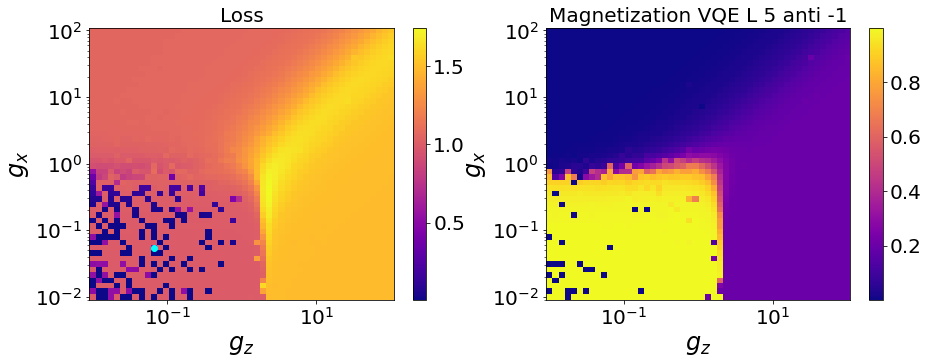

3 / 4 - params (gz, gx) in [(0.054286754393238594, 0.0655128556859551)]


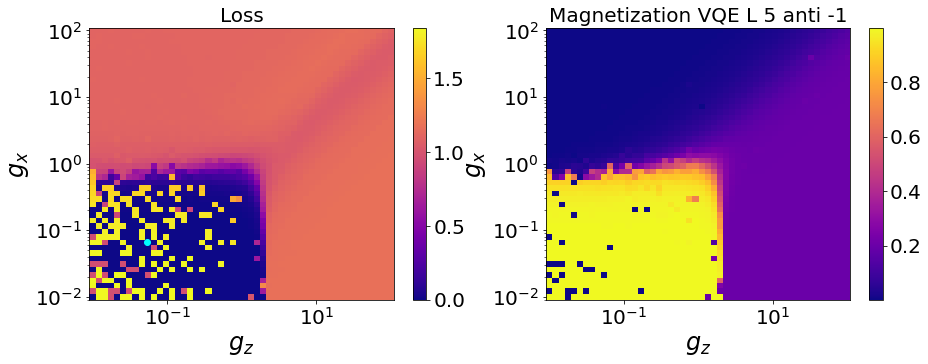

4 / 4 - params (gz, gx) in [(0.0655128556859551, 0.07906043210907697)]


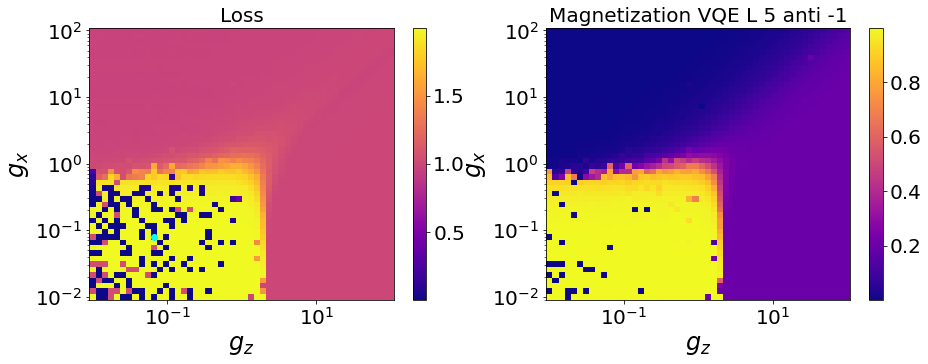

In [63]:
for i,params in enumerate(paramss):
    print(f"{i+1} / {len(paramss)} - params (gz, gx) in {[(gzs[p], gxs[p]) for p in params]}")
    plot_result(np.load(filename2 + ".npz",allow_pickle=True)["costs"][i])
    plt.show()